In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [9]:
# Load dataset
file_path = "exchange_rate.csv"  # Replace with your dataset path
df = pd.read_csv(file_path, parse_dates=["date"], dayfirst=True)
df.set_index("date", inplace=True)


In [10]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None
           Ex_rate
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


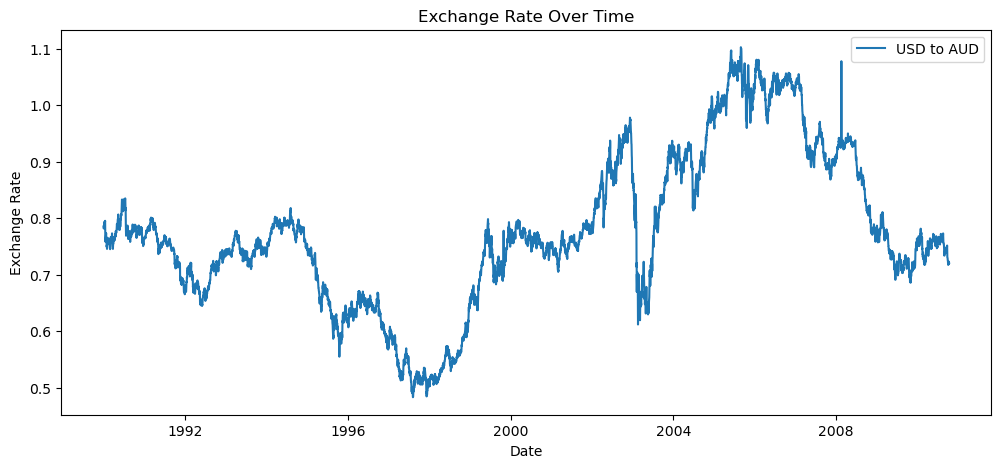

In [11]:
plt.figure(figsize=(12,5))
plt.plot(df["Ex_rate"], label="USD to AUD")
plt.title("Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

In [12]:
print("Missing values:", df.isnull().sum())

Missing values: Ex_rate    0
dtype: int64


In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

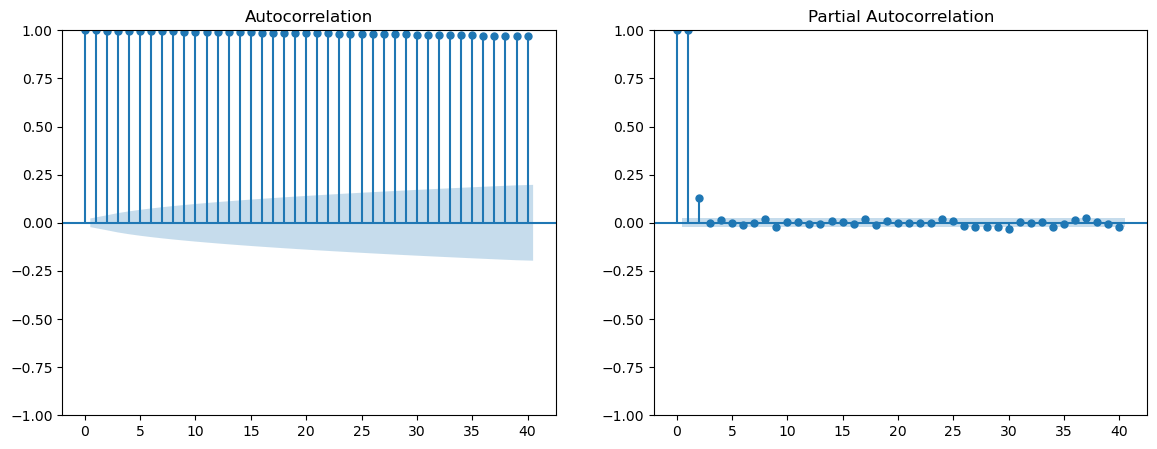

In [14]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
plot_acf(df["Ex_rate"], ax=axes[0], lags=40)
plot_pacf(df["Ex_rate"], ax=axes[1], lags=40)
plt.show()


In [15]:
model_arima = ARIMA(df["Ex_rate"], order=(1,1,1))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 19 Aug 2025   AIC                         -56102.322
Time:                        14:04:07   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

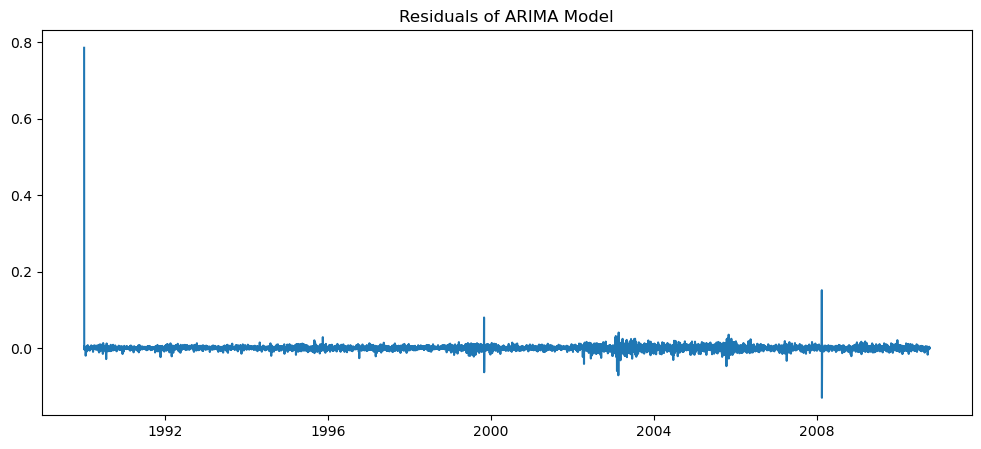

In [16]:
residuals = results_arima.resid
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.show()

In [17]:
forecast_arima = results_arima.get_forecast(steps=30)
pred_arima = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()

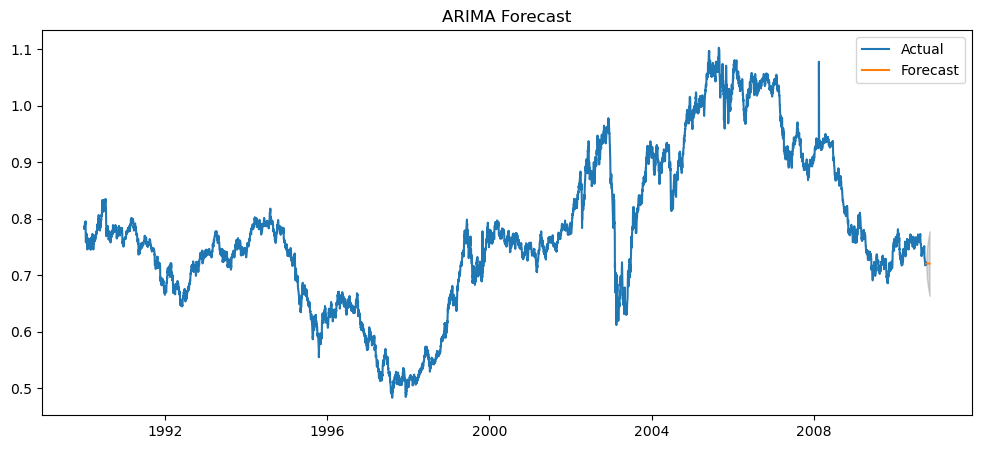

In [18]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Ex_rate"], label="Actual")
plt.plot(pred_arima.index, pred_arima, label="Forecast")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='k', alpha=.15)
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

In [20]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [21]:
hw_model = ExponentialSmoothing(df["Ex_rate"], trend="add", seasonal=None)
hw_fit = hw_model.fit()

In [22]:
hw_forecast = hw_fit.forecast(30)

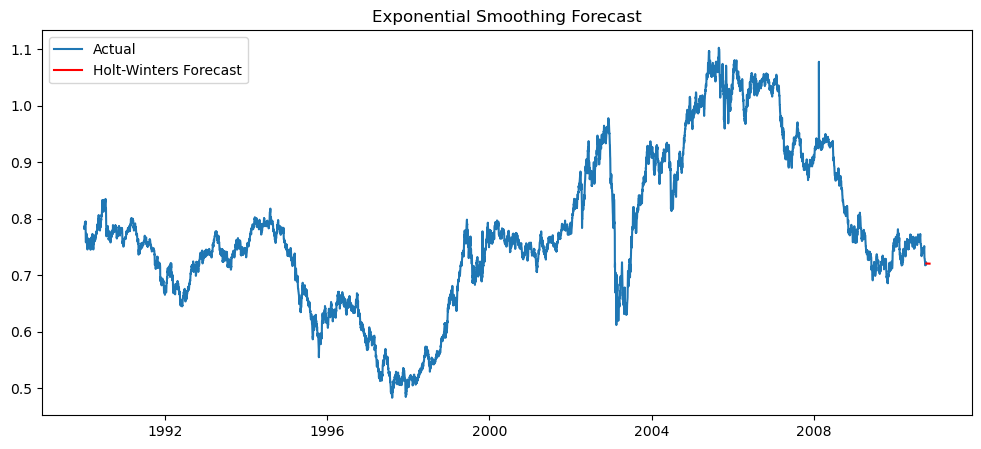

In [23]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Ex_rate"], label="Actual")
plt.plot(hw_forecast.index, hw_forecast, label="Holt-Winters Forecast", color="red")
plt.legend()
plt.title("Exponential Smoothing Forecast")
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [25]:
test_size = 100
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

In [26]:
model_arima = ARIMA(train["Ex_rate"], order=(1,1,1))
results_arima = model_arima.fit()
arima_forecast = results_arima.forecast(steps=test_size)

In [27]:
hw_model = ExponentialSmoothing(train["Ex_rate"], trend="add", seasonal=None)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(test_size)

In [29]:
def error_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred)/true))*100
    return mae, rmse, mape

mae_arima, rmse_arima, mape_arima = error_metrics(test["Ex_rate"], arima_forecast)
mae_hw, rmse_hw, mape_hw = error_metrics(test["Ex_rate"], hw_forecast)

print("ARIMA -> MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_arima, rmse_arima, mape_arima))
print("Holt-Winters -> MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_hw, rmse_hw, mape_hw))

ARIMA -> MAE: 0.0150, RMSE: 0.0206, MAPE: 2.04%
Holt-Winters -> MAE: 0.0149, RMSE: 0.0204, MAPE: 2.02%


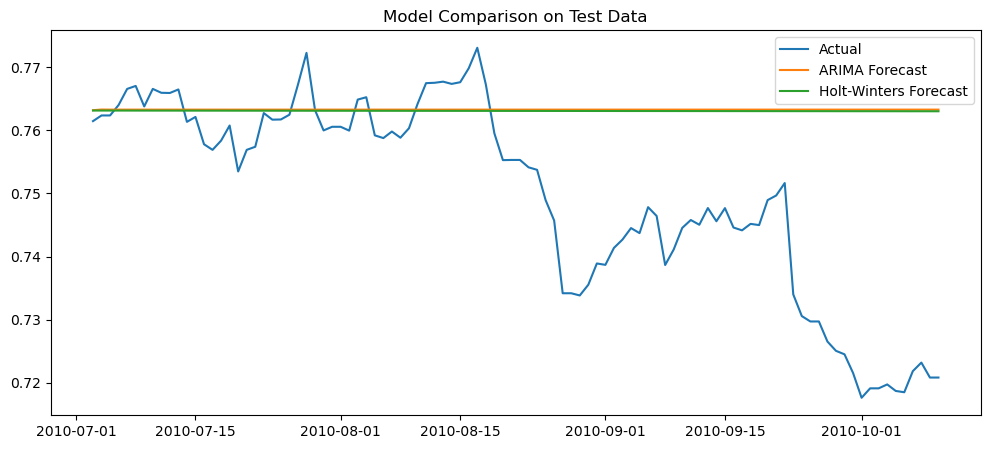

In [30]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test["Ex_rate"], label="Actual")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.plot(test.index, hw_forecast, label="Holt-Winters Forecast")
plt.legend()
plt.title("Model Comparison on Test Data")
plt.show()